<Axes: >

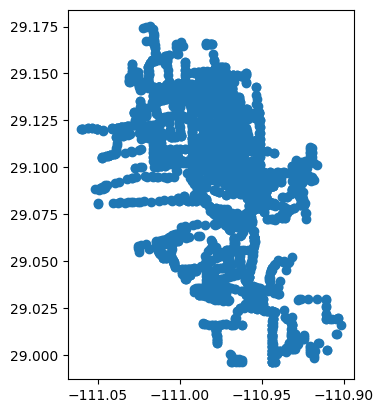

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt


archivo_shp = 'Paradas\Paradas_Hermosillo_unique.shp'
datos_shapefile = gpd.read_file(archivo_shp)

datos_shapefile.plot()



In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

# Calculo de distancia de metros basado en el sistema de cooordenas mi chuy
def distancia_en_metros(lat1, lon1, lat2, lon2):
    R = 6371000  # Radio de la Tierra en metros
    phi1 = lat1 * (math.pi / 180)  # Convertir latitud a radianes
    phi2 = lat2 * (math.pi / 180)
    delta_phi = (lat2 - lat1) * (math.pi / 180)
    delta_lambda = (lon2 - lon1) * (math.pi / 180)

    a = (math.sin(delta_phi / 2) ** 2 +
         math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distancia = R * c
    return distancia

# Función para conectar nodos en un grafo basado en la distancia (100 a 1500), limitando el número de aristas por nodo
def conectar_nodos_por_distancia(G, distancia_maxima=1500, max_aristas_por_nodo=8, distancia_minima=150):
    for node1 in G.nodes():
        distancias = []  # Almacena las distancias y los nodos correspondientes
        for node2 in G.nodes():
            if node1 != node2:
                lat1, lon1 = G.nodes[node1]['Latitude'], G.nodes[node1]['Longitud']
                lat2, lon2 = G.nodes[node2]['Latitude'], G.nodes[node2]['Longitud']
                dist = distancia_en_metros(lat1, lon1, lat2, lon2)
                if dist >= distancia_minima:  # Verificar si la distancia supera el umbral mínimo
                    distancias.append((dist, node2))

        # Ordenar las distancias y tomar los nodos más cercanos
        distancias.sort()
        for i in range(min(max_aristas_por_nodo, len(distancias))):
            dist, node2 = distancias[i]
            G.add_edge(node1, node2, distancia=round(dist, 2))
    return G

# Lo hice un archivo de csv para manejar mas facil la informacion
df = pd.read_csv("parada.csv")

# Creo el grafo en blanco
G = nx.Graph()

# Agrege los nodos al grados 
for index, row in df.iterrows():
    G.add_node(index, Latitude=row['Latitude'], Longitud=row['Longitud'])

# Conectar nodos basados en la distancia de 100 y 1500 metros (máximo de 28 aristas por nodo) ajua
G = conectar_nodos_por_distancia(G)

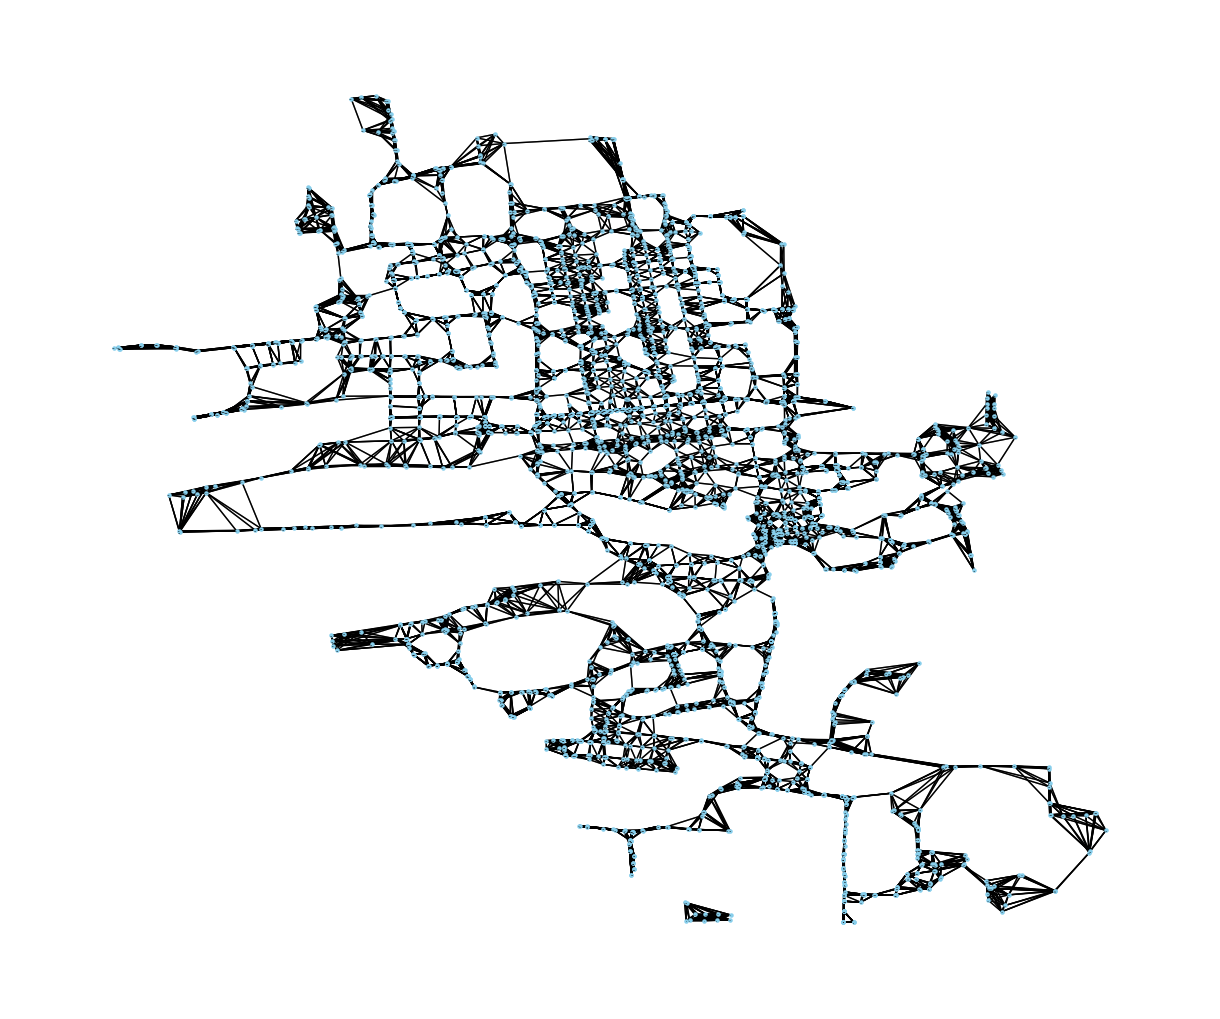

In [7]:

"Se visualiza el grafo"
#Se dibuja el grafo basado en Longitud y Latitud
pos = {node: (G.nodes[node]['Longitud'], G.nodes[node]['Latitude']) for node in G.nodes()}

plt.figure(figsize=(12, 10))  # Sirve para hacer más grande la figura

nx.draw(G, pos, with_labels=True, node_size=5, node_color='skyblue', font_size=0.2)

# Se pone las aristas , el chuqui
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.show()

In [11]:
"""
Funciones para guardar grafos , usar networnx para usarlas
"""
nx.write_graphml(G, "grafo_paradas2.graphml")
nx.write_gexf(G, "grafo_paradas2.gexf")

In [8]:
"""
Se verifico si existe el peso de las aristas
"""

for edge in G.edges(data=True):
    node1, node2, data = edge
    print("Nodo 1:", node1)
    print("Nodo 2:", node2)
    print("Distancia:", data['distancia'], "metros")
    print()

Nodo 1: 0
Nodo 2: 2
Distancia: 161.31 metros

Nodo 1: 0
Nodo 2: 3
Distancia: 161.31 metros

Nodo 1: 0
Nodo 2: 4
Distancia: 161.31 metros

Nodo 1: 0
Nodo 2: 5
Distancia: 161.31 metros

Nodo 1: 0
Nodo 2: 16
Distancia: 304.71 metros

Nodo 1: 0
Nodo 2: 17
Distancia: 304.71 metros

Nodo 1: 0
Nodo 2: 18
Distancia: 304.71 metros

Nodo 1: 0
Nodo 2: 19
Distancia: 304.71 metros

Nodo 1: 1
Nodo 2: 2
Distancia: 161.31 metros

Nodo 1: 1
Nodo 2: 3
Distancia: 161.31 metros

Nodo 1: 1
Nodo 2: 4
Distancia: 161.31 metros

Nodo 1: 1
Nodo 2: 5
Distancia: 161.31 metros

Nodo 1: 1
Nodo 2: 16
Distancia: 304.71 metros

Nodo 1: 1
Nodo 2: 17
Distancia: 304.71 metros

Nodo 1: 1
Nodo 2: 18
Distancia: 304.71 metros

Nodo 1: 1
Nodo 2: 19
Distancia: 304.71 metros

Nodo 1: 2
Nodo 2: 16
Distancia: 252.71 metros

Nodo 1: 2
Nodo 2: 17
Distancia: 252.71 metros

Nodo 1: 2
Nodo 2: 18
Distancia: 252.71 metros

Nodo 1: 2
Nodo 2: 19
Distancia: 252.71 metros

Nodo 1: 2
Nodo 2: 24
Distancia: 493.28 metros

Nodo 1: 2
Nodo 2: 25


In [10]:

"""
Agrega tiempo en segundo a las aristas
"""
# Función para calcular el tiempo de viaje en segundos dados la distancia y la velocidad en metros por segundo
def tiempo_recorrido(distancia, velocidad_metros_segundo):
    tiempo_segundos = distancia / velocidad_metros_segundo
    return tiempo_segundos

# Velocidad del transporte en metros por segundo
velocidad_metros_segundo = (40 * 1000) / 3600  # Convertir km/h a m/s

# Agregar información de tiempo recorrido a las aristas
for edge in G.edges(data=True):
    distancia = edge[2]['distancia']
    tiempo_segundos = tiempo_recorrido(distancia, velocidad_metros_segundo)
    edge[2]['tiempo_recorrido'] = round(tiempo_segundos, 2)

# Crear DataFrame con la información actualizada de las aristas
aristas_data_with_time = []

for edge in G.edges(data=True):
    node1, node2, data = edge
    aristas_data_with_time.append({'Nodo 1': node1, 'Nodo 2': node2, 
                                   'Distancia (metros)': data['distancia'], 
                                   'Tiempo recorrido (segundos)': data['tiempo_recorrido']})

df_aristas_with_time = pd.DataFrame(aristas_data_with_time)
print(df_aristas_with_time)


       Nodo 1  Nodo 2  Distancia (metros)  Tiempo recorrido (segundos)
0           0       2              161.31                        14.52
1           0       3              161.31                        14.52
2           0       4              161.31                        14.52
3           0       5              161.31                        14.52
4           0      16              304.71                        27.42
...       ...     ...                 ...                          ...
14433    2922    2924              391.24                        35.21
14434    2922    2923              542.39                        48.82
14435    2923    2924              160.86                        14.48
14436    2923    2925              384.55                        34.61
14437    2924    2925              223.75                        20.14

[14438 rows x 4 columns]
